In [16]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas 
import uproot3 as uproot ### to read, convert, inspect ROOT TTrees
import matplotlib as mpl

from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

import matplotlib.ticker as mtick # for 1e10 format on Axis


In [19]:
pathTOFile="/eos/user/h/hsharma/ML/MLoutput/NN_pt15/LcTree_BDT_all_pt_15.root";
file=uproot.open(pathTOFile)
tree=file.get('NNoutput')
df=tree.pandas.df()

In [32]:
from scipy.optimize import curve_fit
from scipy import integrate
from matplotlib.offsetbox import AnchoredText
from scipy.integrate import quad

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    minXicMass=2.2
    maxXicMass=2.4
    binWidth=0.005 # GeV/c^2 ~ 4 MeV/c^2
    binsInvMass=int((maxXicMass-minXicMass)/binWidth);

    print('=====================================')
    print('Bins of Inv Mass plot: ',binsInvMass)
    print('=====================================')

    counts, bins = np.histogram(df, bins=binsInvMass, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def pol3_function(x, a, b, c):
        return (a + x*b + x*x*c)
     
    def fit_function3(x, N, mu, sigma, a, b, c):
        return pol3_function(x, a, b, c) + gaus_function(x, N, mu, sigma)
    
#     popt[0] = N
#     popt[1] = mu
#     popt[2] = sigma
#     popt[3] = a
#     popt[4] = b
#     popt[5] = c
     
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    bounds = ([-np.inf, 2.280, 0.010, -np.inf, -np.inf, -np.inf], 
              [ np.inf, 2.287, 0.014,  np.inf,  np.inf, np.inf ])
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function3, x_point, counts, p0 = [100, 2.28, 0.014, 100, -1, 10],maxfev = 20000, bounds=bounds)
    plt.figure(figsize=(8,8))
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='o', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[0], mu=popt[1], sigma=popt[2]), label='Gaus', color='red')
    plt.plot(r, pol3_function(r, a=popt[3], b=popt[4], c=popt[5]), label='pol3', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function3(r, *popt), label='pol3+Gaus', color='blue')
    
    nSigma = 3
    sigRange_Min=popt[1] - nSigma * (popt[2]/2.0)
    sigRange_Max=popt[1] + nSigma * (popt[2]/2.0)
    
    def integrated_model(x, *params):
        # Define the integrated model function by integrating the fitted model function
        result, _ = quad(lambda x: fit_function3(x, *params), sigRange_Min, sigRange_Max)
        return result
    
    integral_value, error = quad(lambda x: integrated_model(r, *popt), sigRange_Min, sigRange_Max)
    uncertainty = np.sqrt(np.dot(np.dot(popt, pcov), popt))
    
    print('Total Integral: ', integral_value, ', ',uncertainty, error)
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, sigRange_Min, sigRange_Max, args=(popt[0], popt[1], popt[2]))[0] / binWidth
    background = integrate.quad(pol3_function, sigRange_Min, sigRange_Max, args=(popt[3], popt[4], popt[5]))[0] / binWidth
    signal_Unc = integrate.quad(gaus_function, sigRange_Min, sigRange_Max, args=(popt[0], popt[1], popt[2]))[1] / binWidth
    background_Unc = integrate.quad(pol3_function, sigRange_Min, sigRange_Max, args=(popt[3], popt[4], popt[5]))[1] / binWidth
    sOverb = signal/background
    
    print(f'Sig : {signal:.0f}+-{signal_Unc:.3f}')
    print(f'Bkg : {background:.0f}+-{background_Unc:.3f}')     
    print(f'S/B : {sOverb:.2f}')     
    significance = abs(signal) / np.sqrt(abs(signal) + abs(background))
    print(f'Significance: {significance:.0f}')
    
    # Compute chi square
    
    y_predicted = fit_function3(x_point, *popt)
    residuals = counts - y_predicted

    num_data_points = len(y_predicted)
    num_params = len(popt)
    num_dof = num_data_points - num_params
    
    print(len(counts), len(y_predicted), len(residuals) )
    chi_squared = np.sum(residuals**2/np.sqrt(counts)**2)
    chi2dof = chi_squared/num_dof
    print('chi2/dof = ', chi2dof)
    
    # ticks and tick-labels
    plt.minorticks_on()
    plt.tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
    plt.tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    txtCuts=r'$p_{\rm T}$ < 8 GeV/c'
    # info on plot
    txt=f'Sig:   {signal:.2f}\nBkg:  {background:.2f}\nS/B:   {sOverb:.3f}\n$S/\sqrt{{S+B}}$: {significance:.2f}\n$\chi^2$/dof = {chi2dof:0.2f}'
    plt.annotate(txt, xy=(0.04, 0.95), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points',fontsize=14, linespacing=2, fontweight='normal', 
                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 7})
    txt2=f'$\mu$:  {popt[1]:.3f}\n$\sigma$:  {popt[2]:.3f}\nBDT:({scoreMin:.2f}-{scoreMax:.2f})'

    plt.annotate(txt2, xy=(0.6, 0.3), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points',fontsize=16, linespacing=2, fontweight='normal', 
                 bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 7})
    # Add some axis labels
    plt.legend(fontsize=18,borderpad=1, labelspacing=0.8, frameon=False)
    plt.xlabel(r'$M_{\Lambda_c^+ \rightarrow pk\pi}$ $(\mathrm{GeV/}\it{c}^2)$',fontsize=20)
    plt.ylabel(f'Counts/({binWidth:.3f} GeV/$c^2$)',fontsize=20)
    plt.gca().set_ylim(top=counts.max()*1.8)
    plt.show()


Bins of Inv Mass plot:  39
Total Integral:  20.84567351602284 ,  18250767976.229107 2.31433467013074e-13
Sig : 7375+-0.000
Bkg : 91890+-0.000
S/B : 0.08
Significance: 23
39 39 39
chi2/dof =  1.909433255679101


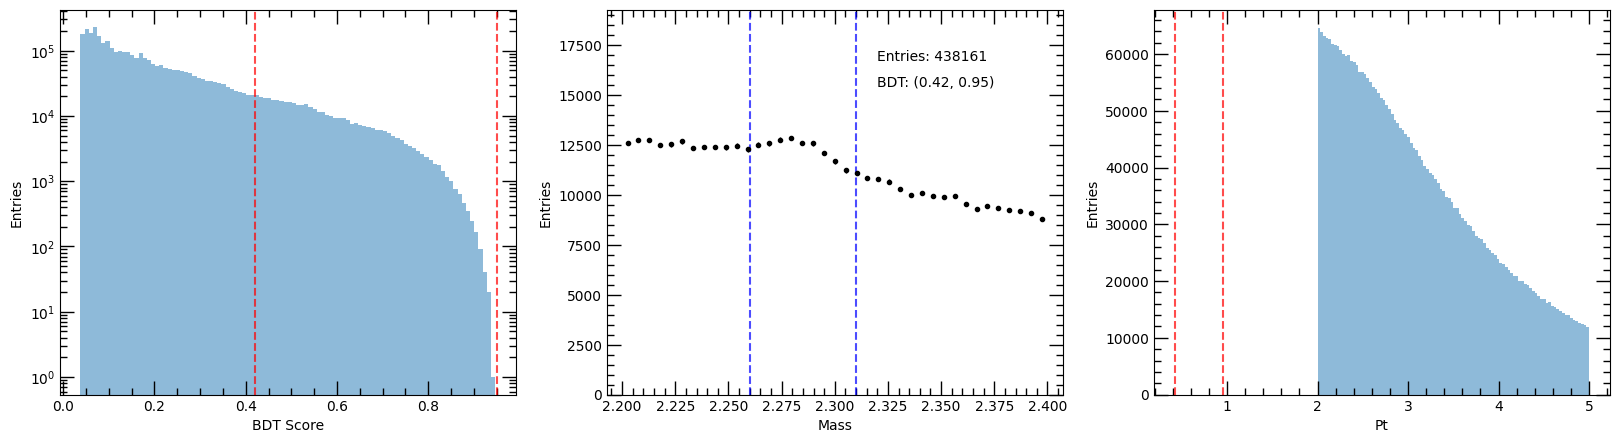

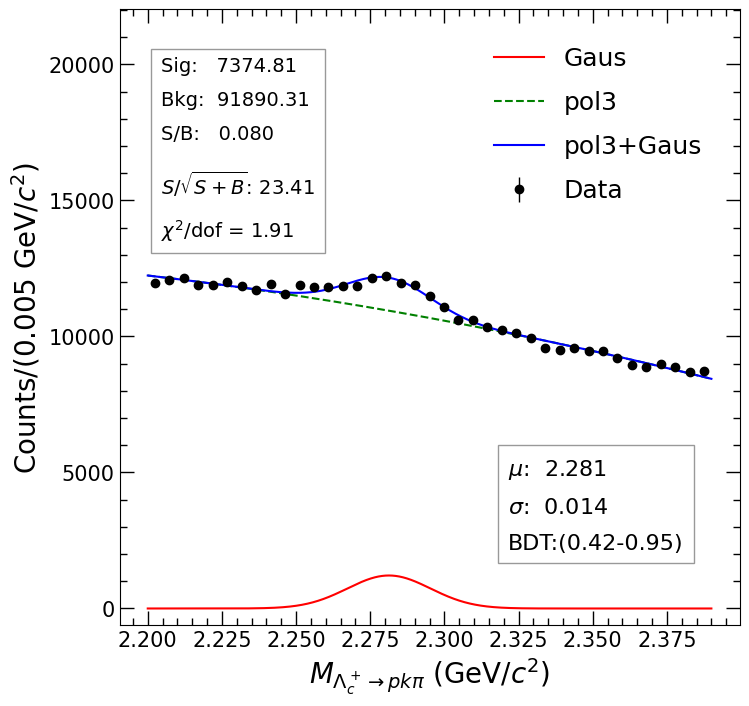

In [51]:
bigTicks=10
smallTicks=5

minMass=2.2
maxMass=2.4
binWidth=0.005 # GeV/c^2 ~ 4 MeV/c^2
binsInvMass=int((maxMass-minMass)/binWidth);


fig, ax = plt.subplots(1,3, figsize=(20,5))

scoreMin=0.42
# scoreMax=1
scoreMax=round(df.model_output.max(),2)

ptMin=1
ptMax=10



scoreCut=f'model_output > {scoreMin:.2f} & model_output < {scoreMax:.2f} & fPt > {ptMin:.2f} & fPt < {ptMax:.2f}'
ax[0].hist(df['model_output'],bins=100,alpha=0.5,log=1)
ax[0].minorticks_on()
ax[0].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[0].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[0].axvline(scoreMin, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[0].axvline(scoreMax, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[0].set_ylabel('Entries')
ax[0].set_xlabel('BDT Score')


counts, bins = np.histogram(df.query(scoreCut)['fM'], bins=binsInvMass)
x_point = 0.5 * (bins[1:] + bins[:-1])
ax[1].errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
ax[1].set_ylim(bottom=0)
ax[1].set_ylim(top=counts.max()*1.5)
ax[1].minorticks_on()
textStr= f'BDT: ({scoreMin:.2f}, {scoreMax:.2f})'
EntriesStr= f'Entries: {counts.sum()}'
ax[1].text(2.32,counts.max()*1.2, textStr )
ax[1].text(2.32,counts.max()*1.3, EntriesStr )
ax[1].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[1].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[1].set_ylabel('Entries')
ax[1].set_xlabel('Mass')
ax[1].axvline(2.26, 0, 1, label='pyplot vertical line',color='b',linestyle='--',alpha=0.7)
ax[1].axvline(2.31, 0, 1, label='pyplot vertical line',color='b',linestyle='--',alpha=0.7)

ax[2].hist(df['fPt'],bins=100,alpha=0.5,log=0)
ax[2].minorticks_on()
ax[2].tick_params('both', top=True, right=True, direction='in',length=bigTicks, width=1, which='major')
ax[2].tick_params('both', top=True, right=True, direction='in',length=smallTicks, width=1, which='minor')
ax[2].axvline(scoreMin, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[2].axvline(scoreMax, 0, 1, label='pyplot vertical line',color='r',linestyle='--',alpha=0.7)
ax[2].set_ylabel('Entries')
ax[2].set_xlabel('Pt')


fit_invmass(df.query(scoreCut)['fM'], fit_range=[2.2, 2.39])